# GLOVe-LSA-SVM
- Uses LSA to capture latent features
- Uses SVM to find optimal hyperplane of separation

---

**TODO**
- Metrics

In [1]:
## IMPORTS
# LSA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler


# SVM
from sklearn.svm import SVC

# GLOVE Embeddings
import spacy

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Preprocessing
import csv
import chardet
import numpy as np
import re
import pandas as pd
import demoji

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/walnuts/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the dataset / read csv
# MAKE SURE CSV IS IN UTF-8 (if tweets have emojis)

## Testing if csv can open (Use for troubleshooting)
# with open('Eng_Tweets.csv') as csv_file:
#   csvFile = csv.reader(csv_file, delimiter=',')
#   for row in csv_file:
#     print(row)

pd.set_option('display.max_colwidth', None)
csv_path = 'Eng_Tweets.csv'

df = pd.read_csv(csv_path)
print("total rows: " + str(len(df)))
df.head() ## head won't show emojis unless using print function

total rows: 2335


,Username,Tweet,Date posted,Label
0,@fudaishii,i'm genuinely going to attempt tonight i can't do this anymore i can't handle all this stress i wish i was never born bro,9/11/24,1.0
1,@yourdystiny,"Becoming less reactive is a huge part of growth & decreasing stress. If you let everything get you worked up, you’ll damage your mind, body & spirit.",9/8/24,0.0
2,@ocenhxu,me ??? tired ??? stressed ??? exhausted ??? i wanna cry ??? yes.,9/8/24,1.0
3,@ifeelgoodto,"skipping meals, irregular sleeping habits, overthinking, stress, tired and drained. that's me, that's my everyday life",9/10/24,0.0
4,@ysuckme,"you deserve to be happy. not confused, not hurt, not stressed, just happy.",9/8/24,0.0


## Preprocessing
- Remove mentions (@)
- Remove hashtags (#)
- Remove URLs
- Replace emojis with textual description (Using demoji)
- Remove stop words

In [3]:
### PREPROCESSING STEPS
def clean_text(text):
  # Remove mentions
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  # Remove hashtags
  text = re.sub(r'#\w+', '', text)
  # Remove URLs
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  # Replace emoji with textual descriptions
  text = demoji.replace_with_desc(text)
  text = re.sub(r'(:[a-zA-Z\s]+:)', r' \1 ', text) # Add spaces around the shortcode
  text = re.sub(r'(:[a-zA-Z\s]+:)', lambda match: match.group(0).replace(' ', '_'), text)
  text = text.strip()
  return text

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)

df = df.dropna() # Get rid of NaN rows
df['Tweet'] = df['Tweet'].apply(clean_text)
df['Tweet'] = df['Tweet'].apply(remove_stopwords)

In [4]:
df.head()

,Username,Tweet,Date posted,Label
0,@fudaishii,i'm genuinely going attempt tonight can't anymore can't handle stress wish never born bro,9/11/24,1.0
1,@yourdystiny,"Becoming less reactive huge part growth & decreasing stress. let everything get worked up, you’ll damage mind, body & spirit.",9/8/24,0.0
2,@ocenhxu,??? tired ??? stressed ??? exhausted ??? wanna cry ??? yes.,9/8/24,1.0
3,@ifeelgoodto,"skipping meals, irregular sleeping habits, overthinking, stress, tired drained. that's me, that's everyday life",9/10/24,0.0
4,@ysuckme,"deserve happy. confused, hurt, stressed, happy.",9/8/24,0.0


In [5]:
df['Label'].value_counts()

Label
0.0    1837
1.0     496
Name: count, dtype: int64

## GloVe Embeddings
- Make sure to run "python -m spacy download en_core_web_md"
- GloVe embeddings are then averaged and standardized
- Train-Test-Validation split = 70% - 20% - 10%
- Uses undersampling to balance the training set

In [6]:
nlp = spacy.load("en_core_web_md", disable=["tagger", "parser", "ner"]) # disable non word-embedding parts of spacy

# Create an empty list to store the embeddings
embeddings = []

# Iterate through the DataFrame
for index, row in df.iterrows():
    tweet = row['Tweet']
    doc = nlp(tweet)

    # Get the embeddings for each token and store them
    tweet_embeddings = [token.vector for token in doc]
    embeddings.append(tweet_embeddings)

# Add the embeddings to the DataFrame as a new column
df['embeddings'] = embeddings

/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [7]:
# Function to average embeddings for a tweet
def average_embeddings(embeddings_list):
    if embeddings_list:
        return np.mean(embeddings_list, axis=0)
    else:
        return np.zeros(300)  # 300 = embedding dimenstion

In [8]:
# Function to split the dataset into train, validation, and test
def split_data(df, train_size=0.7, val_size=0.1, test_size=0.2):
    # 70% into training 30% into validation + testing 
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=42)
    
    # 30% splits 10% into validation and 20% into testing
    val_df, test_df = train_test_split(temp_df, train_size=val_size / (val_size + test_size), random_state=42)
    
    return train_df, val_df, test_df

In [9]:
# Average the sentence embedding into a single entry
df['avg_embedding'] = df['embeddings'].apply(average_embeddings)

# Split the dataset
train_df, val_df, test_df = split_data(df)

X_train = np.array(train_df['avg_embedding'].to_list())
y_train = train_df['Label']
X_val = np.array(val_df['avg_embedding'].to_list())
y_val = val_df['Label']
X_test = np.array(test_df['avg_embedding'].to_list())
y_test = test_df['Label']

# Undersample the training set to balance the classes using RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)  # Automatically balances classes
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Optionally, check the class distribution after undersampling
print(f"Class distribution after undersampling:\n{pd.Series(y_train_resampled).value_counts()}")

Class distribution after undersampling:
Label
0.0    354
1.0    354
Name: count, dtype: int64


## LSA (Latent Semantic Analysis)
- Also uses standard scaler for standardization of values

In [10]:
# Apply LSA (Latent Semantic Analysis) for dimensionality reduction
lsa = TruncatedSVD(n_components=5, random_state=42)  # You can adjust the number of components (5 here)

X_train_lsa = lsa.fit_transform(X_train_resampled)
X_val_lsa = lsa.transform(X_val)
X_test_lsa = lsa.transform(X_test)

# Standardization (scaling)
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_lsa)
X_val = scaler.transform(X_val_lsa)
X_test = scaler.transform(X_test_lsa)

## SVM (Support Vector Machine)

In [11]:
# Train the model using SVC
model = SVC(probability=True)
model.fit(X_train_final, y_train_resampled)

SVC(probability=True)

Validation Accuracy: 0.6223175965665236
Validation Precision: 0.32653061224489793
Validation Recall: 0.5925925925925926
Validation F1 Score: 0.42105263157894735
Validation Balanced Accuracy: 0.6119387543968549
Validation Confusion Matrix: 
[[113  66]
 [ 22  32]]
Test Accuracy: 0.702355460385439
Test Precision: 0.36649214659685864
Test Recall: 0.7954545454545454
Test F1 Score: 0.5017921146953405
Test Balanced Accuracy: 0.7380966658671144
Test Confusion Matrix: 
[[258 121]
 [ 18  70]]
Test ROC AUC: 0.7864895658431279


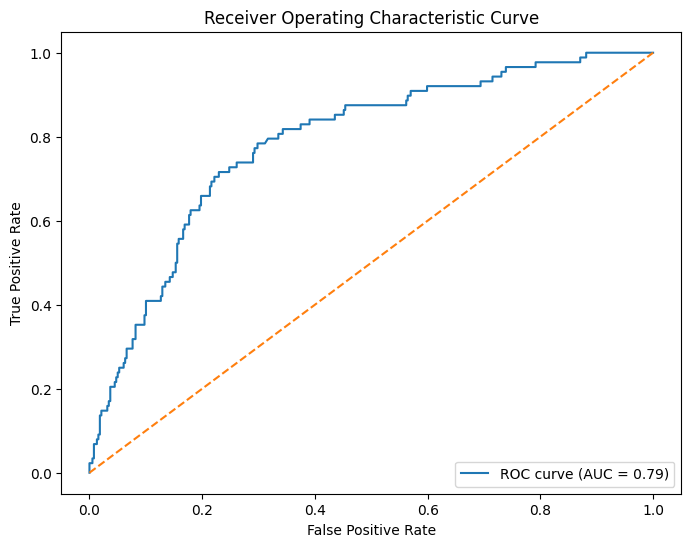

In [13]:
# Evaluation on validation set
y_pred_val = model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
balanced_acc_val = balanced_accuracy_score(y_val, y_pred_val)  # Add balanced accuracy
conf_matrix_val = confusion_matrix(y_val, y_pred_val)

print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")
print(f"Validation F1 Score: {f1_val}")
print(f"Validation Balanced Accuracy: {balanced_acc_val}")  # Print balanced accuracy
print(f"Validation Confusion Matrix: \n{conf_matrix_val}")

# Final evaluation on test set
y_pred_test = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
balanced_acc_test = balanced_accuracy_score(y_test, y_pred_test)  # Add balanced accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")
print(f"Test Balanced Accuracy: {balanced_acc_test}")  # Print balanced accuracy
print(f"Test Confusion Matrix: \n{conf_matrix_test}")

# Compute ROC AUC
y_prob_test = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_prob_test)
print(f"Test ROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()